<a href="https://colab.research.google.com/github/StankoDiego/SOA_EA_2/blob/main/HPC/Stanko_Diego_ejercicio1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Introducción

Se va a implementar un algoritmo para resolver cada uno de los terminos de una serie de Taylor[1].

Se implementaran dos algoritmos, uno que ejecuta de manera secuencial sobre el mismo procesador y otro que resuelve cada termino del polinomio de forma paralela utilizando GPUGPU.


# 2. Armado del ambiente

## 2.1 Armado del ambiente en CPU

No se requiere ejecuciones previas para la ejecución del programa

##2.2 Armado del ambiente en GPU

Se requiere la instalación del modulo de Cuda para Python

In [ ]:
!pip install pycuda

#3. Desarrollo

##3.1 Desarrollo en CPU

Ejecuta el algoritmo de forma secuencial en un mismo procesador.

In [ ]:
# --------------------------------------------
#@title 3.1 Parámetros de ejecución { vertical-output: true }

orden_polinomio =  5#@param {type: "number"}
orden_taylor = 5#@param {type: "number"}
x0 =  3#@param {type: "number"}
x = 4#@param {type: "number"}
# --------------------------------------------

import numpy
import time
import math

def factorial(x):
  if x == 0 or x == 1:
    return 1
  factorial = 1
  for i in range (1, x+1):
    factorial = factorial * i
  return factorial

tiempoTotal = time.time() * 1000
coeficientes = numpy.random.randn(orden_polinomio + 1)
longitud_poli = len(coeficientes)
derivadas = numpy.arange(longitud_poli)

polin_taylor = numpy.zeros(orden_taylor + 1 , dtype=float)
longitud_taylor = len(polin_taylor)


tiempoBucle = time.time() *1000
#----------------------ALGORITMO----------------------------
for idx_t in range(0, longitud_taylor):
  valor = 0
  aux = 0
  
  if idx_t == 0:
    polin_taylor[idx_t] += coeficientes[idx_t]
    idx_p = idx_t + 1
    for idx in range(idx_p, longitud_poli):
      polin_taylor[idx_t] += coeficientes[idx] * math.pow(x0, derivadas[idx])
  
  else:
    if idx_t < longitud_poli - 1:
      aux += coeficientes[idx_t]
      idx_p = idx_t + 1
      resta = math.pow(x - x0, idx_t)
      f = factorial(idx_t)
      for idx in range(idx_p, longitud_poli):
        termino = coeficientes[idx] * derivadas[idx]
        coeficientes[idx] = termino
        derivadas[idx] = derivadas[idx] - 1
        factor = math.pow(x0, derivadas[idx])
        aux += termino * factor        
        
      polin_taylor[idx_t] = (aux * resta) / f        
    else:
      if idx_t >= longitud_poli: 
        
        valor =  0
        polin_taylor[idx_t] = valor
        
      else:
        
        valor =  coeficientes[idx_t]
        resta = math.pow(x - x0, idx_t)
        f = factorial(idx_t)
        polin_taylor[idx_t] = (valor * resta)/ f
#----------------------FINALIZACION----------------------------

tiempoBucle = (time.time() *1000) - tiempoBucle
tiempoTotal = (time.time() *1000) - tiempoTotal
print("C:", coeficientes)
print("T:", polin_taylor)
print("--------------------------------------------------")
print("Tiempo del bucle: " , tiempoBucle , "[ms.]")
print("Tiempo del total: " , tiempoTotal , "[ms.]")

C: [-4.06333478e-01 -8.01496239e-01  1.03950267e-01 -6.85627782e-01
  2.00200237e+01  2.07764581e+02]
T: [482.86248601 787.72059791 511.5388946  165.71917649  26.80474031
   1.73137151]
--------------------------------------------------
Tiempo del bucle:  0.265380859375 [ms.]
Tiempo del total:  0.466796875 [ms.]


##3.2 Desarrollo en GPU

Ejecuta el algoritmo en CPU - GPU

In [ ]:
# --------------------------------------------
#@title 3.1 Parámetros de ejecución { vertical-output: true }

orden_polinomio = 10#@param {type: "number"}
orden_taylor = 5#@param {type: "number"}
x0 = 3#@param {type: "number"}
x = 4#@param {type: "number"}
# --------------------------------------------

import numpy
import time

import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

tiempoTotal = (time.time() * 1000)

# --------------------------------------------
# CPU - Defino la memoria de los vectores en cpu.
coeficientes_cpu = numpy.random.randn(orden_polinomio + 1)
coeficientes_cpu = coeficientes_cpu.astype(numpy.float32())
long_pol = len(coeficientes_cpu)

taylor_cpu = numpy.zeros(orden_taylor + 1, dtype=float)
taylor_cpu = taylor_cpu.astype(numpy.float32())
long_tay = len(coeficientes_cpu)

resultado_cpu = numpy.empty_like(taylor_cpu)
# CPU - reservo la memoria GPU.
coeficientes_gpu = cuda.mem_alloc( coeficientes_cpu.nbytes )
taylor_gpu = cuda.mem_alloc( taylor_cpu.nbytes )
# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( coeficientes_gpu, coeficientes_cpu )
cuda.memcpy_htod( taylor_gpu, taylor_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_taylor(  int long_p,  int long_t,
                                float x0, float x,
                                float* C, float* T){
  
  int idx_t = threadIdx.x + blockIdx.x*blockDim.x;

  int f = 1;
  int i;
  int idx;
  float aux = 0;
  float factor;
  int idx_p;
  float coef = 0;
  float resta;

  for(i = 1; i <= idx_t; i++){
    f*= i;
  }

  if(idx_t == 0){
    for(i = idx_t; i < long_p; i++){
      T[idx_t] += C[i] * pow((double)x0, (double)i);
    }
  } else {
    if(idx_t < long_p - 1){      
      resta = pow((double)x-x0, (double) idx_t);
      coef = C[idx_t];
      for(i = 0; i < idx_t; i++){
        coef *= i + 1;
      }

      idx_p = idx_t + 1;
      aux = 0;
      for(idx = idx_p; idx < long_p; idx++){
         factor = C[idx];
          for(i = 1; i < idx_t + 1; i++){
            factor *= C[idx - i];
          }
          aux += factor * pow((double)x0, (double) idx - 1);
      }

      T[idx_t] = ((aux + coef) * resta) / f;

    } else{

      if(idx_t >= long_p){
        T[idx_t] = 0;
      }else{
        coef = C[idx_t];
        for(i = 0; i < idx_t; i++){
          coef *= i + 1;
        }
        resta = pow((double)x-x0, (double) idx_t);
        T[idx_t] = (coef * resta) / f;
      }
    }
    
  } 
}
""")
#T[idx_t] += C[idx] * idx * pow((double)x0, (double)idx - idx_t);

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_taylor")

tiempo_gpu = time.time()*1000

# GPU - Ejecuta el kernel.
# TODO: Falta consultar limites del GPU, para armar las dimensiones correctamente.
dim_hilo = 256
dim_bloque = numpy.int( (long_tay+dim_hilo-1) / dim_hilo )
print( "Thread x: ", dim_hilo, ", Bloque x:", dim_bloque )

#TODO: Ojo, con los tipos de las variables en el kernel.
kernel( numpy.int32(long_pol), numpy.int32(long_tay),
       numpy.float32(x0), numpy.float32(x),      
       coeficientes_gpu, taylor_gpu,
       block=( dim_hilo, 1, 1 ),grid=(dim_bloque, 1,1) )

tiempo_gpu = time.time()*1000 - tiempo_gpu

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( resultado_cpu, taylor_gpu)

tiempoTotal = time.time() *1000 - tiempoTotal
print("C:", coeficientes_cpu)
print("T:", taylor_cpu)
print("R:", resultado_cpu)
print("-----------------------------------------------")
print("Thread x: ", dim_hilo, ", Bloque x:", dim_bloque )
print("Tiempo CPU: ", tiempoTotal, "[ms]" )
print("Tiempo GPU: ", tiempo_gpu, "[ms]" )

Thread x:  256 , Bloque x: 1
C: [ 2.0069659   0.37852317  0.58933175  0.01678326 -0.09624083 -0.8216089
  1.3253883   0.91632026  0.42315808 -2.277388   -0.26547503]
T: [0. 0. 0. 0. 0. 0.]
R: [-5.4953871e+04  7.0535796e+03 -1.6739603e+02 -6.5291809e+02
  5.2136536e+02 -4.7735043e+01]
-----------------------------------------------
Thread x:  256 , Bloque x: 1
Tiempo CPU:  2.94921875 [ms]
Tiempo GPU:  0.5029296875 [ms]


#4. Tabla de pasos

##4.1 Tabla de pasos CPU

Tabla de ejecucion de forma secuencial

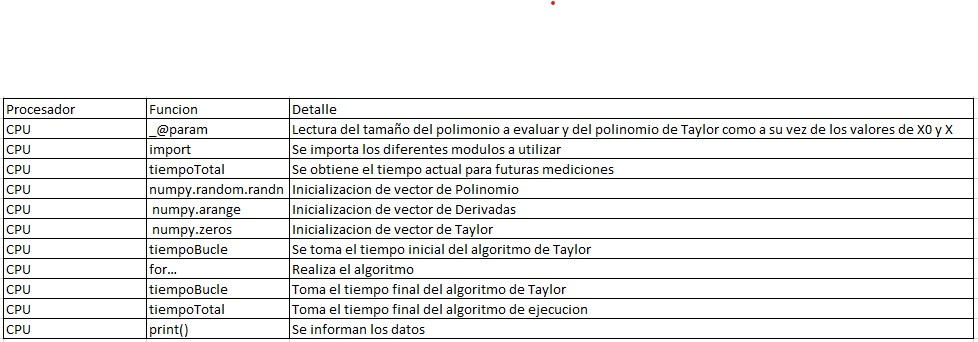

##4.2 Tabla de pasos GPU

Tabla de ejecucion en forma paralela

#5. Conclusiones